# Conditional Autoencoder for Asset Pricing - Part 2: The Model

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

### if Colab

In [230]:
import os

if 'COLAB_GPU' in os.environ:
    print("Running on Colab")
    from google.colab import drive
    drive.mount('/content/drive')
    # Get the current working directory
    path = os.getcwd()
    # Print the path
    print("Current Path:", path)
    # 이동할 디렉토리 경로
    path = '/content/drive/MyDrive/Colab Notebooks'
    # 디렉토리 변경
    os.chdir(path)
else:
    print("Not running on Colab")

Not running on Colab


In [231]:
import warnings
warnings.filterwarnings('ignore')

In [232]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [233]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [234]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [235]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [236]:
results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [237]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [238]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: KR2_results\asset_pricing\autoencoder.h5
/close                      frame        (shape->[5858,858])
/factor/beta                frame        (shape->[658062,1])
/factor/betasq              frame        (shape->[658062,1])
/factor/chmom               frame        (shape->[744340,1])
/factor/dolvol              frame        (shape->[777778,1])
/factor/idiovol             frame        (shape->[658062,1])
/factor/ill                 frame        (shape->[628189,1])
/factor/indmom              frame        (shape->[767616,1])
/factor/maxret              frame        (shape->[780979,1])
/factor/mom12m              frame        (shape->[744340,1])
/factor/mom1m               series       (shape->[784469])  
/factor/mom36m              frame        (shape->[658553,1])
/factor/mvel                frame        (shape->[788034,1])
/factor/retvol              frame        (shape->[784469,1])
/factor/turn                frame        (shape->[771259

### Weekly returns

In [239]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1990':, :], :])

# 램 문제 발생으로 인한 1993 -> 2013

In [241]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [242]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [243]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [244]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1045044 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      787971 non-null  float64
 1   beta         658062 non-null  float64
 2   betasq       658062 non-null  float64
 3   chmom        744340 non-null  float64
 4   dolvol       777778 non-null  float64
 5   idiovol      658062 non-null  float64
 6   ill          628189 non-null  float64
 7   indmom       767616 non-null  float64
 8   maxret       780979 non-null  float64
 9   mom12m       744340 non-null  float64
 10  mom1m        784469 non-null  float64
 11  mom36m       658553 non-null  float64
 12  mvel         787656 non-null  float64
 13  retvol       784469 non-null  float64
 14  turn         771259 non-null  float64
 15  turn_std     781354 non-null  float64

In [245]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

### 주식 개수, Beta 개수

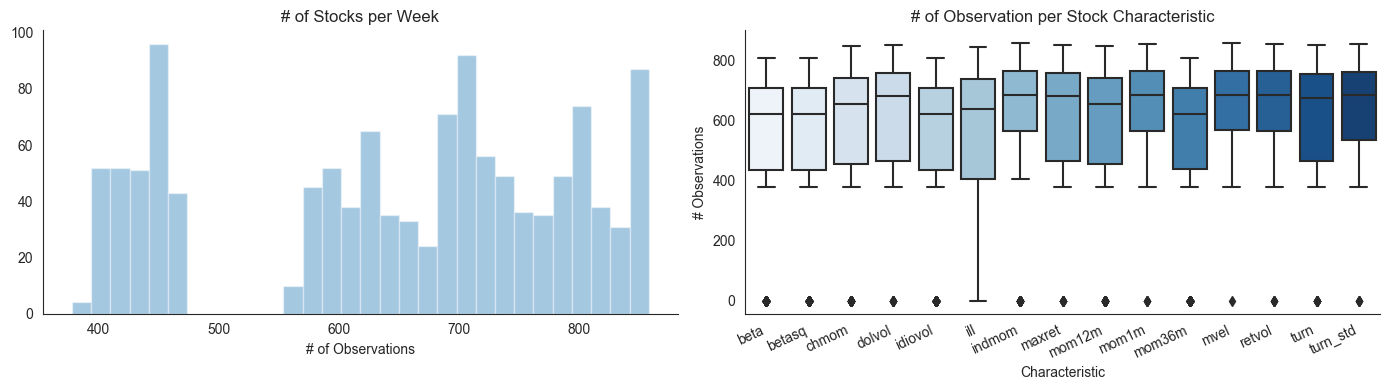

In [246]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0], bins=30)
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()
    # fig.savefig(results_path / 'of Stocks per Week', dpi=600)

In [247]:
nobs_by_characteristic

,Characteristic,# Observations
0,beta,0
1,beta,0
2,beta,0
3,beta,0
4,beta,0
...,...,...
18265,turn_std,853
18266,turn_std,854
18267,turn_std,856
18268,turn_std,856


In [248]:
nobs_by_characteristic[nobs_by_characteristic["Characteristic"] == "turn_std"].sort_values(by="# Observations")

,Characteristic,# Observations
17052,turn_std,0
17054,turn_std,0
17977,turn_std,0
17053,turn_std,0
17055,turn_std,378
...,...,...
18261,turn_std,853
18266,turn_std,854
18268,turn_std,856
18267,turn_std,856


### Rank-normalize characteristics

In [249]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [250]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1045044 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2023-05-12 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      787971 non-null  float64
 1   beta         658062 non-null  float64
 2   betasq       658062 non-null  float64
 3   chmom        744340 non-null  float64
 4   dolvol       777778 non-null  float64
 5   idiovol      658062 non-null  float64
 6   ill          628189 non-null  float64
 7   indmom       767616 non-null  float64
 8   maxret       780979 non-null  float64
 9   mom12m       744340 non-null  float64
 10  mom1m        784469 non-null  float64
 11  mom36m       658553 non-null  float64
 12  mvel         787656 non-null  float64
 13  retvol       784469 non-null  float64
 14  turn         771259 non-null  float64
 15  turn_std     781354 non-null  float64

In [251]:
data.index.names

FrozenList(['date', 'ticker'])

In [252]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,787971.000000,6.580620e+05,658062.000000,7.443400e+05,777778.000000,658062.000000,6.281890e+05,767616.000000,780979.000000,744340.000000,7.844690e+05,658553.000000,7.876560e+05,784469.000000,771259.000000,781354.000000,787593.000000
mean,0.003311,-2.616659e-07,-0.000003,-2.354048e-07,-0.000013,-0.000001,-1.706637e-05,0.001858,-0.000001,-0.000001,-6.476835e-07,-0.000001,-4.751343e-07,-0.000011,-0.000014,-0.000018,0.003307
std,0.072245,5.782771e-01,0.578280,5.782461e-01,0.578261,0.578276,5.782350e-01,0.590767,0.578235,0.578248,5.782317e-01,0.578279,5.782348e-01,0.578253,0.578260,0.578263,0.072220
min,-0.972147,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-0.972147
25%,-0.028455,-5.007122e-01,-0.500718,-5.006776e-01,-0.500689,-0.500699,-5.006899e-01,-0.495916,-0.500642,-0.500736,-5.006528e-01,-0.500721,-5.006923e-01,-0.500680,-0.500669,-0.500681,-0.028436
50%,0.000000,4.215423e-05,0.000026,-9.497526e-06,0.000055,0.000042,1.432557e-07,0.014002,-0.000031,0.000053,5.101654e-05,-0.000006,-9.863743e-05,0.000021,0.000050,0.000048,0.000000
75%,0.028571,5.007229e-01,0.500723,5.007073e-01,0.500687,0.500718,5.006864e-01,0.481914,0.500677,0.500718,5.006900e-01,0.500711,5.006832e-01,0.500697,0.500678,0.500686,0.028571
max,2.697885,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,2.697885


In [253]:
data = data.loc[idx[:'2023', :], :]

In [254]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [255]:
data = data.fillna(-2)

In [256]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [261]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [275]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [276]:
n_tickers

858

In [277]:
n_characteristics

15

### Input Layer

In [278]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [279]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [287]:
pfo_factor = Dense(units=n_characteristics, name='pfo_factor')(input_factor)
output_factor = Dense(units=n_factors, name='output_factor')(pfo_factor)

### Output Layer

In [288]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [289]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [290]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)
    
    pfo_factor = Dense(units=n_characteristics, name='pfo_factor')(input_factor)
    output_factor = Dense(units=n_factors, name='output_factor')(pfo_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [291]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 858, 15)]    0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 858, 8)       128         ['input_beta[0][0]']             
                                                                                                  
 input_factor (InputLayer)      [(None, 858)]        0           []                               
                                                                                                  
 batch_norm (BatchNormalization  (None, 858, 8)      32          ['hidden_layer[0][0]']           
 )                                                                                          

### 모델 시각화

In [292]:
model_img_file = (results_path / 'model.png' )
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True,
                          dpi=600)

model.save(results_path / 'model_img.h5')

## Train Model

### Cross-validation parameters

In [293]:
YEAR = 52

In [310]:
cv = MultipleTimeSeriesCV(n_splits=5, # 5
                          train_period_length=15*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [311]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [312]:
factor_opts = [2, 3, 4, 5, 6] # 2, 3, 4, 5, 6
unit_opts = [8, 16, 32] # 8, 16, 32

In [313]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [314]:
batch_size = 64

In [315]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [316]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from keras.utils import Sequence

# Define a custom data generator to feed data to the model
class DataGenerator(Sequence):
    def __init__(self, X1, X2, y, batch_size):
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X1 = self.X1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X2 = self.X2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X1, batch_X2], batch_y

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

from keras.callbacks import EarlyStopping
# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

In [317]:
units = 8
n_factors = 3
print("units:", units, ", n_factors:", n_factors)
scores = []
for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
    X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                train_idx,
                                                                                val_idx)
    train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
    val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
    model = make_model(hidden_units=units, n_factors=n_factors)
    for epoch in range(250):
        model.fit_generator(train_gen,
                            validation_data=val_gen,
                            epochs=epoch + 1,
                            initial_epoch=epoch, verbose=False, shuffle=True, callbacks=[ClearMemory(), early_stop])
        y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
        y_true = y_val.stack().values
        date_index = y_val.stack().index
        result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                'y_true': y_true},
                                index=date_index)
                    .replace(-2, np.nan).dropna())
        r0 = spearmanr(result.y_true, result.y_pred)[0]
        r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                    x.y_true)[0])

        scores.append([units, n_factors, fold, epoch, r0,
                        r1.mean(), r1.std(), r1.median()])
        if epoch % 50 == 0:
            print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                f'{r1.mean():6.2%} | {r1.median():6.2%}')
        
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 8 , n_factors: 3
39:40:27 | 3 | 08 | 00-000 |  1.72% |  3.14% |  2.00%
39:46:36 | 3 | 08 | 00-050 |  0.81% |  1.40% |  0.90%
39:52:44 | 3 | 08 | 00-100 |  1.18% |  0.62% |  0.66%
39:59:03 | 3 | 08 | 00-150 |  1.37% |  0.10% | -0.28%
40:04:56 | 3 | 08 | 00-200 |  1.03% |  0.51% | -0.73%
40:10:36 | 3 | 08 | 01-000 |  2.31% |  0.73% |  0.60%
40:16:17 | 3 | 08 | 01-050 | -2.84% |  0.59% |  3.67%
40:21:50 | 3 | 08 | 01-100 | -3.64% |  0.96% |  2.99%
40:27:26 | 3 | 08 | 01-150 | -3.80% |  1.20% |  3.92%
40:33:06 | 3 | 08 | 01-200 | -4.49% | -0.29% | -0.30%
40:38:35 | 3 | 08 | 02-000 |  6.83% |  5.78% |  5.25%
40:44:07 | 3 | 08 | 02-050 |  4.55% |  5.56% |  7.30%
40:49:40 | 3 | 08 | 02-100 |  3.01% |  5.19% |  7.46%
40:55:16 | 3 | 08 | 02-150 |  2.39% |  6.15% |  7.66%
41:00:46 | 3 | 08 | 02-200 |  0.51% |  4.34% |  6.07%
41:06:13 | 3 | 08 | 03-000 |  0.97% |  1.00% | -0.26%
41:11:41 | 3 | 08 | 03-050 | -0.14% |  0.62% |  2.11%
41:17:20 | 3 | 08 | 03-100 |  0.34% |  1.14% |  2.88%
41:2

In [91]:
start = time()
for units, n_factors in param_grid:
    print("units:", units, ", n_factors:", n_factors)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        model = make_model(hidden_units=units, n_factors=n_factors)
        for epoch in range(250):
            model.fit_generator(train_gen,
                                validation_data=val_gen,
                                epochs=epoch + 1,
                                initial_epoch=epoch, verbose=False, shuffle=True, callbacks=ClearMemory())
            y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
            y_true = y_val.stack().values
            date_index = y_val.stack().index
            result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                    'y_true': y_true},
                                   index=date_index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')
            
        scores = pd.DataFrame(scores, columns=cols)
        scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 8 , n_factors: 2
00:00:02 | 2 | 08 | 00-000 | -4.05% | -4.42% | -1.47%
00:00:27 | 2 | 08 | 00-050 | -2.38% | -3.92% | -2.41%
00:00:52 | 2 | 08 | 00-100 | -2.23% | -3.75% | -1.28%
00:01:18 | 2 | 08 | 00-150 | -2.61% | -3.10% | -1.47%
00:01:43 | 2 | 08 | 00-200 | -4.43% | -1.99% |  0.08%
00:02:13 | 2 | 08 | 01-000 |  2.36% |  2.37% |  2.07%
00:02:43 | 2 | 08 | 01-050 | -0.41% |  0.47% |  1.27%
00:03:14 | 2 | 08 | 01-100 | -0.43% |  0.35% |  0.28%
00:03:42 | 2 | 08 | 01-150 | -0.44% |  1.06% |  1.12%
00:04:10 | 2 | 08 | 01-200 | -0.31% |  1.68% |  0.06%
00:04:39 | 2 | 08 | 02-000 | -2.53% | -3.54% | -5.19%
00:05:07 | 2 | 08 | 02-050 | -1.39% | -1.57% | -1.27%
00:05:35 | 2 | 08 | 02-100 | -1.68% | -1.03% | -0.70%
00:06:02 | 2 | 08 | 02-150 | -2.18% | -0.89% | -0.04%
00:06:29 | 2 | 08 | 02-200 | -2.61% | -0.87% |  0.40%
00:06:57 | 2 | 08 | 03-000 | -0.82% | -2.10% | -1.72%
00:07:24 | 2 | 08 | 03-050 | -1.14% | -0.81% |  0.25%
00:07:52 | 2 | 08 | 03-100 | -0.62% | -0.08% |  0.06%
00:0

### Evaluate Results

In [318]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
print(scores)
scores = pd.concat(scores)

[     units  n_factors  fold  epoch   ic_mean  ic_daily_mean  ic_daily_std  \
0        8          3     0      0  0.017229       0.031378      0.089028   
1        8          3     0      1  0.011602      -0.000100      0.086461   
2        8          3     0      2  0.005690       0.002270      0.084440   
3        8          3     0      3  0.012815       0.013447      0.090168   
4        8          3     0      4  0.013983       0.013425      0.090880   
..     ...        ...   ...    ...       ...            ...           ...   
245      8          3     0    245  0.019281       0.009177      0.094405   
246      8          3     0    246  0.019499       0.007717      0.093689   
247      8          3     0    247  0.013158       0.001211      0.091735   
248      8          3     0    248  0.018188       0.005341      0.088630   
249      8          3     0    249  0.010297       0.002083      0.092527   

     ic_daily_median  
0           0.019999  
1          -0.008484  
2    

In [319]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            500 non-null    int64  
 1   n_factors        500 non-null    int64  
 2   fold             500 non-null    int64  
 3   epoch            500 non-null    int64  
 4   ic_mean          500 non-null    float64
 5   ic_daily_mean    500 non-null    float64
 6   ic_daily_std     500 non-null    float64
 7   ic_daily_median  500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


In [320]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [324]:
avg.nlargest(n=50, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
36,3,8,36,0.021097,0.032065,0.031935
0,3,8,0,0.017229,0.031378,0.019999
19,3,8,19,0.006346,0.017253,0.018472
23,3,8,23,0.008843,0.020951,0.016793
22,3,8,22,-0.002534,0.009432,0.016300
21,3,8,21,0.011908,0.022143,0.015048
24,3,8,24,0.002780,0.013394,0.014745
42,3,8,42,0.009878,0.015758,0.014701
38,3,8,38,0.012004,0.008996,0.014524
18,3,8,18,0.005584,0.016014,0.013357


In [322]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
3         8              3      8     36  0.021097       0.032065   
          8              3      8      0  0.017229       0.031378   
          8              3      8     19  0.006346       0.017253   
          8              3      8     23  0.008843       0.020951   
          8              3      8     22 -0.002534       0.009432   

                 ic_daily_median  
n_factors units                   
3         8             0.031935  
          8             0.019999  
          8             0.018472  
          8             0.016793  
          8             0.016300

TypeError: no numeric data to plot

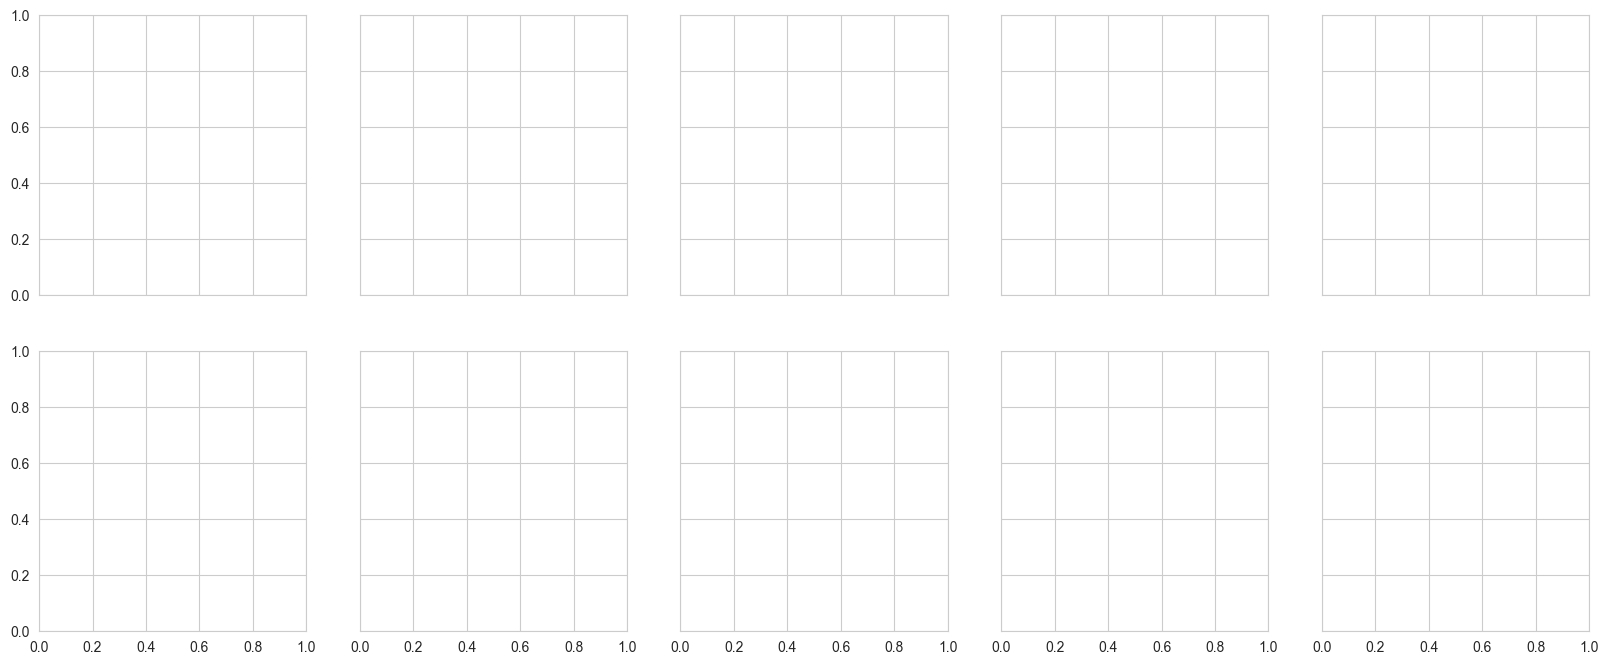

In [323]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=600);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [325]:
n_factors = 3
units = 8
batch_size = 64
first_epoch = 50
last_epoch = 80

In [326]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        
        model.fit_generator(train_gen,
                    validation_data=val_gen,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True, callbacks=[ClearMemory(), early_stop])
        epoch_preds.append(pd.Series(model.predict_generator(val_gen, callbacks=[ClearMemory(), early_stop]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12: early stopping
Epoch 11: early stopping
Epoch 17: early stopping
Epoch 14: early stopping


  3%|▎         | 1/30 [06:24<3:05:36, 384.02s/it]

Epoch 11: early stopping
Epoch 26: early stopping
Epoch 20: early stopping
Epoch 11: early stopping


  7%|▋         | 2/30 [13:43<3:14:23, 416.57s/it]

Epoch 49: early stopping
Epoch 15: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 11: early stopping


 10%|█         | 3/30 [19:16<2:50:20, 378.55s/it]

Epoch 12: early stopping
Epoch 23: early stopping
Epoch 14: early stopping
Epoch 12: early stopping


 13%|█▎        | 4/30 [26:00<2:48:24, 388.64s/it]

Epoch 11: early stopping
Epoch 11: early stopping
Epoch 12: early stopping
Epoch 27: early stopping


 17%|█▋        | 5/30 [32:50<2:45:02, 396.11s/it]

Epoch 12: early stopping
Epoch 13: early stopping
Epoch 13: early stopping
Epoch 12: early stopping


 20%|██        | 6/30 [39:09<2:36:13, 390.55s/it]

Epoch 14: early stopping
Epoch 18: early stopping
Epoch 16: early stopping
Epoch 12: early stopping


 23%|██▎       | 7/30 [45:59<2:32:07, 396.84s/it]

Epoch 11: early stopping
Epoch 11: early stopping
Epoch 17: early stopping
Epoch 16: early stopping


 27%|██▋       | 8/30 [52:34<2:25:19, 396.33s/it]

Epoch 45: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 13: early stopping
Epoch 11: early stopping


 30%|███       | 9/30 [58:04<2:11:24, 375.47s/it]

Epoch 34: early stopping
Epoch 12: early stopping
Epoch 17: early stopping
Epoch 17: early stopping
Epoch 12: early stopping


 33%|███▎      | 10/30 [1:03:30<2:00:05, 360.28s/it]

Epoch 38: early stopping
Epoch 13: early stopping
Epoch 19: early stopping
Epoch 15: early stopping
Epoch 13: early stopping


 37%|███▋      | 11/30 [1:09:21<1:53:07, 357.26s/it]

Epoch 13: early stopping
Epoch 13: early stopping
Epoch 13: early stopping
Epoch 13: early stopping
Epoch 18: early stopping


 40%|████      | 12/30 [1:13:33<1:37:36, 325.34s/it]

Epoch 13: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 19: early stopping
Epoch 12: early stopping


 43%|████▎     | 13/30 [1:17:32<1:24:47, 299.25s/it]

Epoch 18: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 19: early stopping
Epoch 11: early stopping


 47%|████▋     | 14/30 [1:21:59<1:17:08, 289.29s/it]

Epoch 27: early stopping
Epoch 11: early stopping
Epoch 18: early stopping
Epoch 17: early stopping
Epoch 24: early stopping


 50%|█████     | 15/30 [1:27:50<1:16:58, 307.91s/it]

Epoch 46: early stopping
Epoch 12: early stopping
Epoch 23: early stopping
Epoch 12: early stopping
Epoch 11: early stopping


 53%|█████▎    | 16/30 [1:34:07<1:16:41, 328.68s/it]

Epoch 42: early stopping
Epoch 12: early stopping
Epoch 24: early stopping
Epoch 20: early stopping
Epoch 12: early stopping


 57%|█████▋    | 17/30 [1:40:29<1:14:45, 345.01s/it]

Epoch 45: early stopping
Epoch 13: early stopping
Epoch 11: early stopping
Epoch 16: early stopping
Epoch 11: early stopping


 60%|██████    | 18/30 [1:46:18<1:09:14, 346.20s/it]

Epoch 45: early stopping
Epoch 12: early stopping
Epoch 18: early stopping
Epoch 22: early stopping
Epoch 11: early stopping


 63%|██████▎   | 19/30 [1:52:46<1:05:43, 358.52s/it]

Epoch 54: early stopping
Epoch 12: early stopping
Epoch 12: early stopping
Epoch 16: early stopping
Epoch 15: early stopping


 67%|██████▋   | 20/30 [1:59:10<1:01:03, 366.39s/it]

Epoch 48: early stopping
Epoch 19: early stopping
Epoch 14: early stopping
Epoch 13: early stopping
Epoch 13: early stopping


 70%|███████   | 21/30 [2:05:35<55:45, 371.74s/it]  

Epoch 42: early stopping
Epoch 13: early stopping
Epoch 14: early stopping
Epoch 15: early stopping
Epoch 16: early stopping


 73%|███████▎  | 22/30 [2:11:47<49:36, 372.02s/it]

Epoch 55: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 12: early stopping
Epoch 14: early stopping


 77%|███████▋  | 23/30 [2:17:57<43:19, 371.29s/it]

Epoch 49: early stopping
Epoch 13: early stopping
Epoch 13: early stopping
Epoch 14: early stopping
Epoch 11: early stopping


 80%|████████  | 24/30 [2:23:56<36:46, 367.71s/it]

Epoch 62: early stopping
Epoch 13: early stopping
Epoch 14: early stopping
Epoch 17: early stopping
Epoch 12: early stopping


 83%|████████▎ | 25/30 [2:31:08<32:14, 386.84s/it]

Epoch 54: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 12: early stopping
Epoch 11: early stopping


 87%|████████▋ | 26/30 [2:37:53<26:10, 392.51s/it]

Epoch 52: early stopping
Epoch 13: early stopping
Epoch 11: early stopping
Epoch 16: early stopping
Epoch 11: early stopping


 90%|█████████ | 27/30 [2:44:27<19:38, 392.96s/it]

Epoch 39: early stopping
Epoch 12: early stopping
Epoch 12: early stopping
Epoch 12: early stopping
Epoch 12: early stopping


 93%|█████████▎| 28/30 [2:49:47<12:22, 371.06s/it]

Epoch 41: early stopping
Epoch 13: early stopping
Epoch 11: early stopping
Epoch 13: early stopping
Epoch 12: early stopping


 97%|█████████▋| 29/30 [2:55:16<05:58, 358.38s/it]

Epoch 65: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 12: early stopping
Epoch 11: early stopping


100%|██████████| 30/30 [3:02:07<00:00, 364.24s/it]


In [327]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()

In [331]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 223080 entries, (Timestamp('2018-05-25 00:00:00'), '000020.KS') to (Timestamp('2023-05-12 00:00:00'), '950210.KS')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   50      223080 non-null  float32
 1   51      223080 non-null  float32
 2   52      223080 non-null  float32
 3   53      223080 non-null  float32
 4   54      223080 non-null  float32
 5   55      223080 non-null  float32
 6   56      223080 non-null  float32
 7   57      223080 non-null  float32
 8   58      223080 non-null  float32
 9   59      223080 non-null  float32
 10  60      223080 non-null  float32
 11  61      223080 non-null  float32
 12  62      223080 non-null  float32
 13  63      223080 non-null  float32
 14  64      223080 non-null  float32
 15  65      223080 non-null  float32
 16  66      223080 non-null  float32
 17  67      223080 non-null  float32
 18  68      223080 non-null  float32
 19 

In [332]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')

In [333]:
predictions_combined

50        51        52        53        54  \
date       ticker                                                        
2018-05-25 000020.KS  0.040641  0.081166  0.097349  0.098991  0.119275   
           000040.KS  0.092641  0.104553  0.120835  0.118723  0.125409   
           000050.KS  0.101895  0.143689  0.120337  0.130517  0.143669   
           000070.KS  0.083896  0.104633  0.122944  0.110993  0.121802   
           000075.KS  0.114436  0.121420  0.125571  0.125743  0.126555   
...                        ...       ...       ...       ...       ...   
2023-05-12 451800.KS  0.043185  0.040875  0.023914  0.028295  0.021827   
           452260.KS  0.032751  0.029912  0.019208  0.024241  0.024190   
           453340.KS  0.024177  0.026142  0.020134  0.024196  0.021928   
           900140.KS  0.040498  0.032382  0.014603  0.017197  0.011275   
           950210.KS -0.013945  0.003388 -0.002909 -0.000422 -0.013596   

                            55        56        57        58        59  ...  \
date       ticker                                                       ...   
2018-05-25 000020.KS  0.118682  0.115823  0.138521  0.128921  0.119598  ...   
           000040.KS  0.124329  0.126815  0.148523  0.132446  0.121560  ...   
           000050.KS  0.150319  0.117780  0.141134  0.126851  0.107337  ...   
           000070.KS  0.116582  0.124479  0.143900  0.131539  0.122675  ...   
           000075.KS  0.131347  0.118277  0.142389  0.130253  0.119357  ...   
...                        ...       ...       ...       ...       ...  ...   
2023-05-12 451800.KS  0.017456  0.022532  0.025019  0.030964  0.040930  ...   
           452260.KS  0.023607  0.026725  0.030483  0.037750  0.048165  ...   
           453340.KS  0.024761  0.031764  0.042945  0.065138  0.075654  ...   
           900140.KS  0.009519  0.009810  0.012886  0.009735  0.016366  ...   
           950210.KS -0.015738 -0.011282 -0.011584 -0.014105 -0.008136  ...   

                            70        71        72        73        74  \
date       ticker                                                        
2018-05-25 000020.KS  0.166055  0.167745  0.167015  0.172683  0.161027   
           000040.KS  0.160247  0.153608  0.148865  0.153466  0.153959   
           000050.KS  0.147569  0.143726  0.139907  0.145353  0.146795   
           000070.KS  0.166656  0.162356  0.159780  0.166870  0.158356   
           000075.KS  0.155218  0.153405  0.151002  0.158347  0.156245   
...                        ...       ...       ...       ...       ...   
2023-05-12 451800.KS  0.066590  0.070182  0.077850  0.063280  0.064770   
           452260.KS  0.057060  0.061336  0.069746  0.058287  0.059121   
           453340.KS  0.086080  0.087899  0.091441  0.074112  0.077464   
           900140.KS  0.026200  0.029312  0.028507  0.029512  0.033366   
           950210.KS  0.010118  0.015144  0.021265  0.027270  0.029878   

                            75        76        77        78        79  
date       ticker                                                       
2018-05-25 000020.KS  0.170037  0.165164  0.162555  0.175062  0.163776  
           000040.KS  0.152358  0.148719  0.156427  0.162235  0.153175  
           000050.KS  0.143260  0.139743  0.146252  0.149947  0.141103  
           000070.KS  0.165013  0.160635  0.161776  0.172344  0.161516  
           000075.KS  0.154041  0.151334  0.154143  0.161630  0.151395  
...                        ...       ...       ...       ...       ...  
2023-05-12 451800.KS  0.065536  0.065173  0.069061  0.071161  0.077495  
           452260.KS  0.059042  0.059423  0.067136  0.064378  0.072080  
           453340.KS  0.093499  0.080278  0.079729  0.091098  0.089868  
           900140.KS  0.034181  0.034423  0.043177  0.038895  0.042410  
           950210.KS  0.028687  0.031764  0.041370  0.034814  0.038642  

[223080 rows x 30 columns]